<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ben-Fox-Homework-2-CV-Pokemon-Autoencoder" data-toc-modified-id="Ben-Fox-Homework-2-CV-Pokemon-Autoencoder-1">Ben Fox Homework 2 CV Pokemon Autoencoder</a></span><ul class="toc-item"><li><span><a href="#05/05/2019" data-toc-modified-id="05/05/2019-1.1">05/05/2019</a></span></li><li><span><a href="#Simple-autoencoder-with-1-dense-layer-(no-RNN-or-CNN)" data-toc-modified-id="Simple-autoencoder-with-1-dense-layer-(no-RNN-or-CNN)-1.2">Simple autoencoder with 1 dense layer (no RNN or CNN)</a></span></li><li><span><a href="#CNN-Autoencoder" data-toc-modified-id="CNN-Autoencoder-1.3">CNN Autoencoder</a></span></li><li><span><a href="#Row-LSTM-Autoencoder" data-toc-modified-id="Row-LSTM-Autoencoder-1.4">Row LSTM Autoencoder</a></span></li></ul></li></ul></div>

## Ben Fox Homework 2 CV Pokemon Autoencoder
### 05/05/2019

In [1]:
import numpy as np
import tensorflow as tf
import math
from keras.utils.np_utils import to_categorical
tf.set_random_seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Reshape, RepeatVector, TimeDistributed, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
#! wget http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Pokemon_creation/image.rar # get pokemon images

In [3]:
# read pokemon images from file
import imageio
import glob

poke = []
for im_path in glob.glob("./HW2/pokemon/*.png"):
    im = imageio.imread(im_path)
    im = im[10:30,10:30,:3] # get rid of 4th dim (all 0s), and crop to 20x20 images
    poke.append(im)
poke = np.array(poke)

In [4]:
poke.shape

(792, 20, 20, 3)

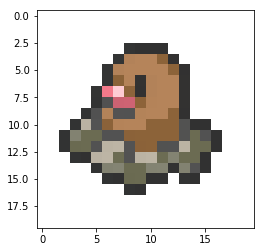

In [5]:
plt.imshow(poke[7])

In [6]:
# indexes for train/test split 
idx = np.random.choice(poke.shape[0], replace = False, size = int((poke.shape[0]*0.1))) # 10% test set

In [7]:
# normalize images and create train/test set
poke = poke.astype('float32')
x_train = poke[[i for i in range(poke.shape[0]) if i not in idx]]
x_test = poke[idx]
x_train /= 255
x_test /= 255

In [8]:
x_train.shape, x_test.shape

((713, 20, 20, 3), (79, 20, 20, 3))

### Simple autoencoder with 1 dense layer (no RNN or CNN)

In [9]:
x_train_easy = x_train.reshape([x_train.shape[0],-1])
x_test_easy = x_test.reshape([x_test.shape[0],-1])

In [10]:
x_train_easy.shape, x_test_easy.shape

((713, 1200), (79, 1200))

In [11]:
encoding_dim_easy = 512

# input
input_poke_easy = Input(shape=(1200,))
# encoder
x = Dense(encoding_dim_easy)(input_poke_easy)
x = BatchNormalization()(x)
encoder_easy = Activation('relu')(x)
# decoded
x = Dense(1200)(encoder_easy)
x = BatchNormalization()(x)
decoder_easy = Activation('sigmoid')(x)

# model
autoencoder_easy = Model(input_poke_easy, decoder_easy)

In [12]:
autoencoder_easy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

In [13]:
history_easy = autoencoder_easy.fit(x_train_easy, x_train_easy, epochs=100, batch_size=32, 
                shuffle=True, validation_data=(x_test_easy, x_test_easy), verbose=0)

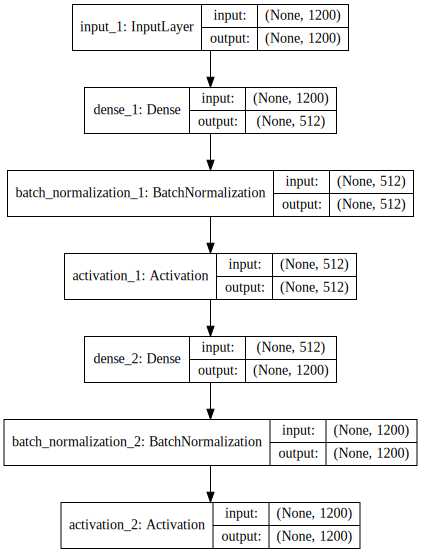

In [14]:
SVG(model_to_dot(autoencoder_easy, show_shapes=True).create(prog='dot', format='svg'))

Text(0, 0.5, 'Accuracy')

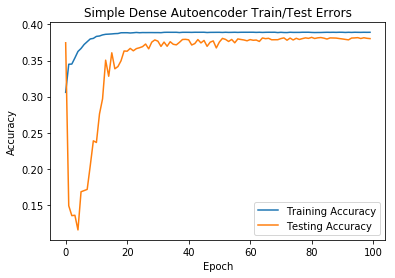

In [15]:
plt.plot(history_easy.history['acc'], label = 'Training Accuracy')
plt.plot(history_easy.history['val_acc'], label = 'Testing Accuracy')
plt.legend()
plt.title('Simple Dense Autoencoder Train/Test Errors')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [16]:
decoded_imgs_easy = autoencoder_easy.predict(x_test_easy)

In [17]:
x_test.shape

(79, 20, 20, 3)

In [18]:
decoded_imgs_easy = decoded_imgs_easy.reshape(x_test.shape)

In [19]:
def plot_orig_decode(originals, decoded):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

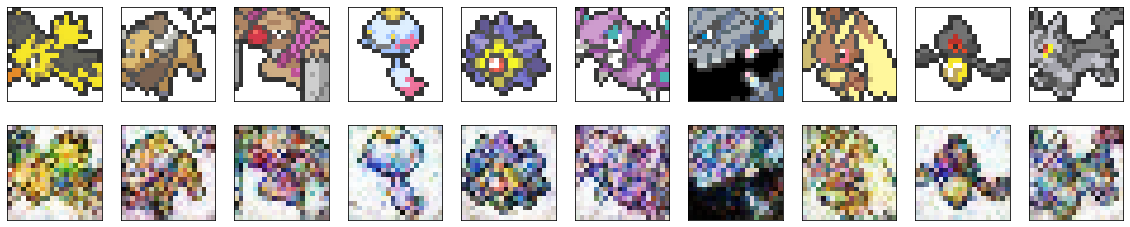

In [20]:
plot_orig_decode(x_test, decoded_imgs_easy)

In [21]:
autoencoder_easy.metrics_names

['loss', 'acc', 'mean_squared_error']

In [22]:
autoencoder_easy.evaluate(x_test_easy, x_test_easy, verbose = 1)

79/79 [==============================] - 0s 355us/step


[0.4424562823923328, 0.38030591908889483, 0.033631615057776246]

### CNN Autoencoder

In [43]:
input_poke_cnn = Input(shape=(20, 20, 3))  # placeholder for input image

x = Conv2D(64, (3, 3), padding='same')(input_poke_cnn)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(x)

x = UpSampling2D((2, 2))(encoded_cnn)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded_cnn = Activation('sigmoid')(x)

autoencoder_cnn = Model(input_poke_cnn, decoded_cnn)
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc', 'mse'])

In [44]:
history_cnn = autoencoder_cnn.fit(x_train, x_train, epochs=100, batch_size=32, 
                                  shuffle=True, validation_data=(x_test, x_test), verbose = 0)

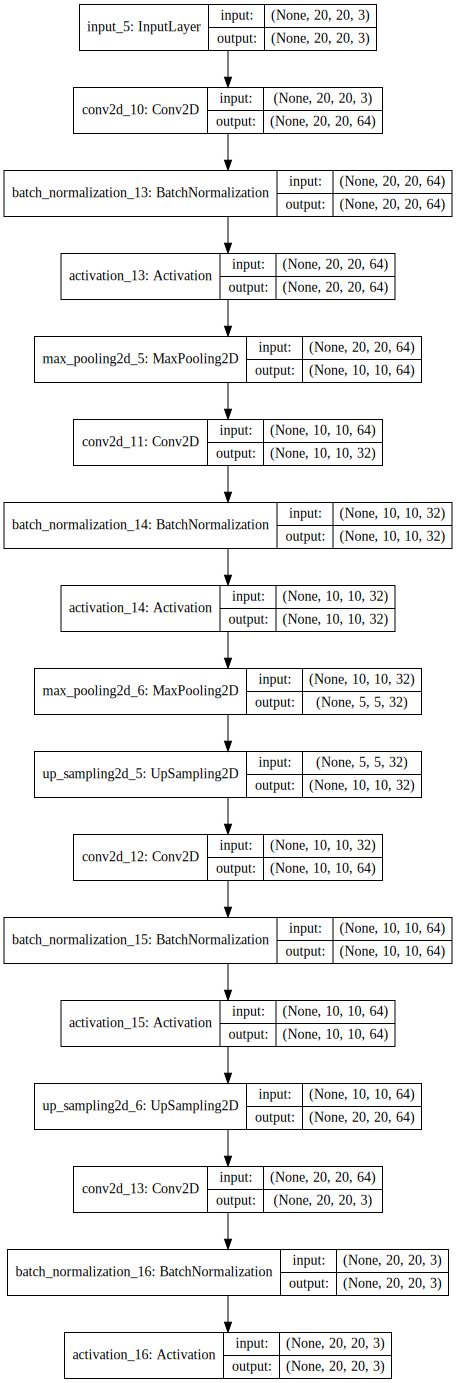

In [45]:
SVG(model_to_dot(autoencoder_cnn, show_shapes=True).create(prog='dot', format='svg'))

Text(0, 0.5, 'Accuracy')

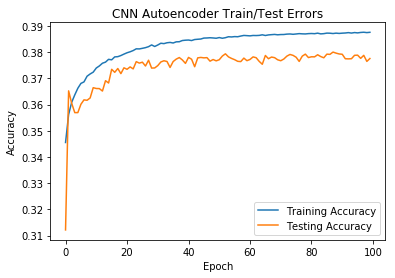

In [46]:
plt.plot(history_cnn.history['acc'], label = 'Training Accuracy')
plt.plot(history_cnn.history['val_acc'], label = 'Testing Accuracy')
plt.legend()
plt.title('CNN Autoencoder Train/Test Errors')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [47]:
decoded_imgs_cnn = autoencoder_cnn.predict(x_test)

In [48]:
decoded_imgs_cnn.shape

(79, 20, 20, 3)

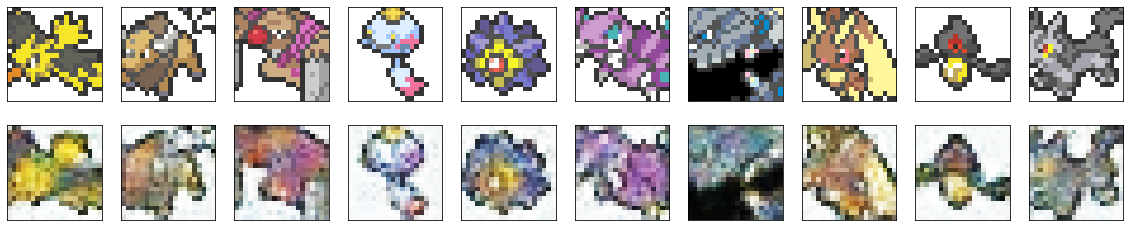

In [49]:
plot_orig_decode(x_test, decoded_imgs_cnn)

In [50]:
autoencoder_cnn.evaluate(x_test, x_test, verbose = 1)

79/79 [==============================] - 0s 2ms/step


[0.42967553417893906, 0.3775738424892667, 0.032426184444110606]

### Row LSTM Autoencoder

In [51]:
lstm_x_train = x_train.reshape(x_train.shape[0], 1,-1)
lstm_x_test = x_test.reshape(x_test.shape[0], 1,-1)

In [32]:
input_poke_lstm = Input(shape=(1,1200))  # placeholder for input image

# encode
encoder_lstm = LSTM(512, return_sequences=False, activation = 'relu', input_shape=(1,1200))(input_poke_lstm)

# decode
x = RepeatVector(1)(encoder_lstm)
x = LSTM(1200, return_sequences=True, activation = 'relu')(x)
x = Dense(1200)(x)
x = BatchNormalization()(x)
decoder_lstm = Activation('sigmoid')(x)

autoencoder_lstm = Model(input_poke_lstm, decoder_lstm)
autoencoder_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

In [55]:
history_lstm = autoencoder_lstm.fit(lstm_x_train, lstm_x_train, epochs=100, batch_size=32, 
                                  shuffle=True, validation_data=(lstm_x_test, lstm_x_test), verbose = 0)

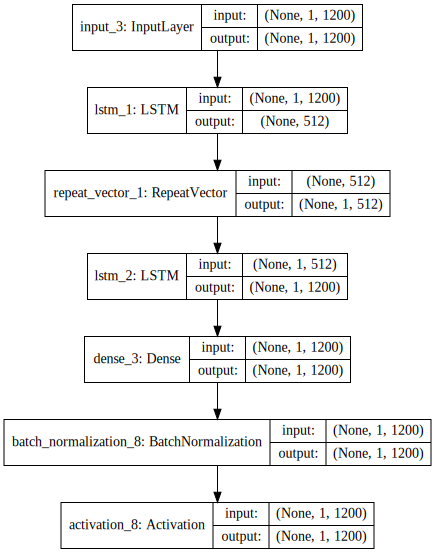

In [53]:
SVG(model_to_dot(autoencoder_lstm, show_shapes=True).create(prog='dot', format='svg'))

Text(0, 0.5, 'Accuracy')

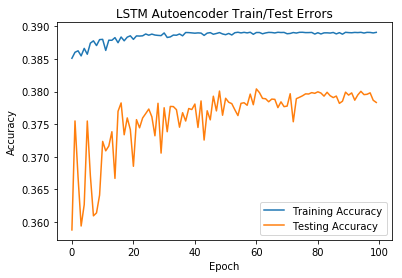

In [56]:
plt.plot(history_lstm.history['acc'], label = 'Training Accuracy')
plt.plot(history_lstm.history['val_acc'], label = 'Testing Accuracy')
plt.legend()
plt.title('LSTM Autoencoder Train/Test Errors')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [57]:
decoded_imgs_lstm = autoencoder_lstm.predict(lstm_x_test, verbose = 1)
decoded_imgs_lstm.shape

79/79 [==============================] - 1s 11ms/step


(79, 1, 1200)

In [58]:
decoded_imgs_lstm = decoded_imgs_lstm.reshape(x_test.shape)

In [59]:
x_test.shape, decoded_imgs_lstm.shape

((79, 20, 20, 3), (79, 20, 20, 3))

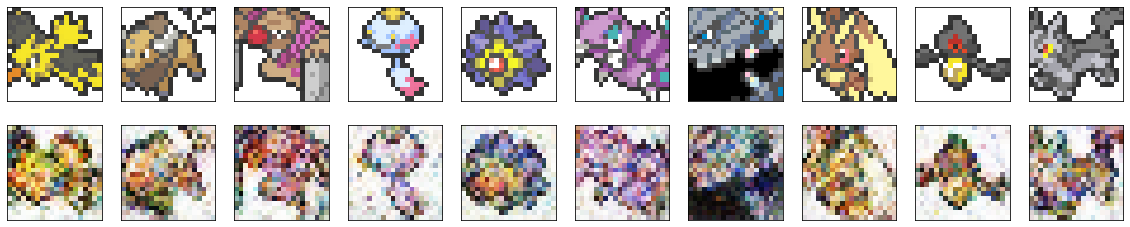

In [60]:
plot_orig_decode(x_test, decoded_imgs_lstm)

In [61]:
autoencoder_lstm.evaluate(lstm_x_test, lstm_x_test, verbose = 1)

79/79 [==============================] - 0s 2ms/step


[0.46325088188618047, 0.3783333343041094, 0.042121572113489804]

In [64]:
history_easy.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error'])

Text(0, 0.5, 'MSE Loss')

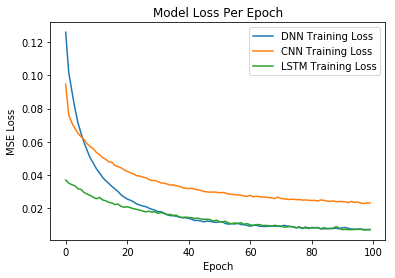

In [66]:
plt.plot(history_easy.history['mean_squared_error'], label = 'DNN Training Loss')
plt.plot(history_cnn.history['mean_squared_error'], label = 'CNN Training Loss')
plt.plot(history_lstm.history['mean_squared_error'], label = 'LSTM Training Loss')
plt.legend()
plt.title('Model Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

Text(0, 0.5, 'Accuracy')

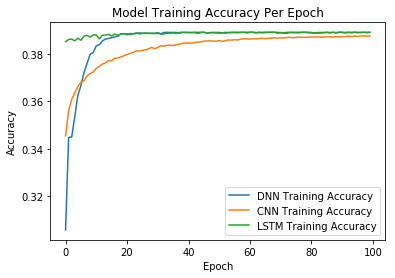

In [68]:
plt.plot(history_easy.history['acc'], label = 'DNN Training Accuracy')
plt.plot(history_cnn.history['acc'], label = 'CNN Training Accuracy')
plt.plot(history_lstm.history['acc'], label = 'LSTM Training Accuracy')
plt.legend()
plt.title('Model Training Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

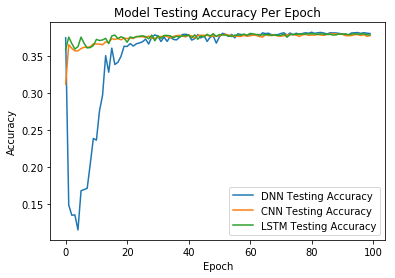

In [69]:
plt.plot(history_easy.history['val_acc'], label = 'DNN Testing Accuracy')
plt.plot(history_cnn.history['val_acc'], label = 'CNN Testing Accuracy')
plt.plot(history_lstm.history['val_acc'], label = 'LSTM Testing Accuracy')
plt.legend()
plt.title('Model Testing Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')